Epoch 0: Loss = 12.829843, Data Loss = 12.806257, Physics Loss = 0.023586, Lambda = 0.9990
Epoch 500: Loss = 0.987293, Data Loss = 0.884758, Physics Loss = 0.102535, Lambda = 0.8643
Epoch 1000: Loss = 0.391405, Data Loss = 0.354522, Physics Loss = 0.036883, Lambda = 1.2521
Epoch 1500: Loss = 0.131327, Data Loss = 0.115161, Physics Loss = 0.016166, Lambda = 1.5616
Epoch 2000: Loss = 0.034555, Data Loss = 0.030264, Physics Loss = 0.004291, Lambda = 1.7696
Epoch 2500: Loss = 0.007263, Data Loss = 0.005766, Physics Loss = 0.001497, Lambda = 1.8980
Epoch 3000: Loss = 0.001564, Data Loss = 0.000793, Physics Loss = 0.000771, Lambda = 1.9621
Epoch 3500: Loss = 0.000502, Data Loss = 0.000088, Physics Loss = 0.000414, Lambda = 1.9876
Epoch 4000: Loss = 0.000225, Data Loss = 0.000011, Physics Loss = 0.000214, Lambda = 1.9958
Epoch 4500: Loss = 0.000102, Data Loss = 0.000002, Physics Loss = 0.000100, Lambda = 1.9982

--- RESULTADOS ---
Valor real de lambda: 2.0
Valor aprendido de lambda: 1.9991


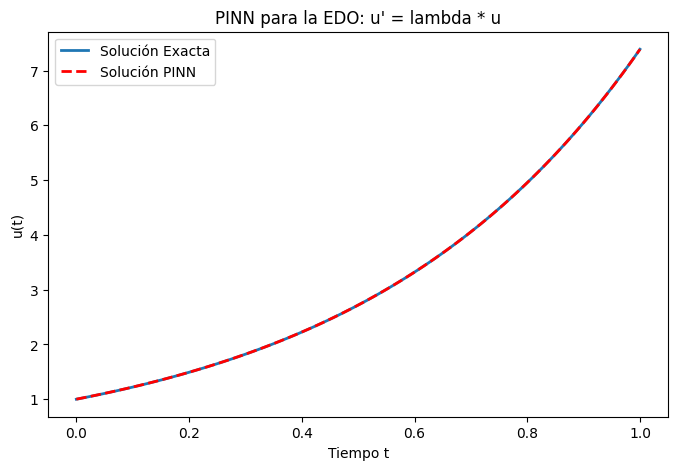

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Configuración: uso de dispositivo (CPU o GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# 1. Generación de datos sintéticos
# ---------------------------
lambda_real = 2.0        # Valor real del parámetro lambda en la EDO: u' = lambda*u
n_data = 50              # Número de puntos de datos
n_collocation = 50       # Número de puntos de colocation para evaluar la ecuación física

# Generamos puntos de tiempo en el intervalo [0,1]
t_data = np.linspace(0, 1, n_data).reshape(-1, 1)
# Solución exacta: u(t)=exp(lambda_real*t)
u_data = np.exp(lambda_real * t_data)

# Convertimos los datos a tensores de PyTorch
# Se marca t_data_tensor y t_collocation_tensor con requires_grad=True para calcular derivadas
t_data_tensor = torch.tensor(t_data, dtype=torch.float32, device=device, requires_grad=True)
u_data_tensor = torch.tensor(u_data, dtype=torch.float32, device=device)
t_collocation = np.linspace(0, 1, n_collocation).reshape(-1, 1)
t_collocation_tensor = torch.tensor(t_collocation, dtype=torch.float32, device=device, requires_grad=True)

# ---------------------------
# 2. Definición de la red neuronal PINN
# ---------------------------
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # Definimos una red neuronal sencilla con dos capas ocultas
        self.net = nn.Sequential(
            nn.Linear(1, 20),  # Capa de entrada a primera capa oculta (20 neuronas)
            nn.Tanh(),         # Función de activación hiperbólica tangente
            nn.Linear(20, 20), # Segunda capa oculta
            nn.Tanh(),
            nn.Linear(20, 1)   # Capa de salida: predice u(t)
        )

    def forward(self, t):
        return self.net(t)

# Inicializamos el modelo y lo enviamos al dispositivo configurado
model = PINN().to(device)

# ---------------------------
# 3. Definición del parámetro físico a aprender
# ---------------------------
# Se inicializa lambda_param como un parámetro a optimizar (inicialmente 1.0)
lambda_param = torch.nn.Parameter(torch.tensor([1.0], device=device))

# ---------------------------
# 4. Configuración del optimizador
# ---------------------------
# Se optimizan tanto los parámetros de la red como lambda_param
optimizer = optim.Adam(list(model.parameters()) + [lambda_param], lr=0.001)

# ---------------------------
# 5. Definición de la función de pérdida
# ---------------------------
def loss_function(model, t_data, u_data, t_collocation, lambda_param):
    # Pérdida en los datos: diferencia entre la salida de la red y los datos reales
    u_pred = model(t_data)
    data_loss = torch.mean((u_pred - u_data)**2)

    # Pérdida física: residuo de la EDO en puntos de colocation
    # Calculamos la predicción en puntos de colocation
    u_collocation = model(t_collocation)
    # Calculamos la derivada de u respecto a t usando autograd
    u_collocation_grad = torch.autograd.grad(
        u_collocation, t_collocation,
        grad_outputs=torch.ones_like(u_collocation),
        create_graph=True
    )[0]
    # Residuo de la EDO: u_t - lambda*u, que debe ser 0
    ode_residual = u_collocation_grad - lambda_param * u_collocation
    physics_loss = torch.mean(ode_residual**2)

    # La pérdida total es la suma de la pérdida en los datos y la pérdida física
    total_loss = data_loss + physics_loss
    return total_loss, data_loss, physics_loss

# ---------------------------
# 6. Entrenamiento del modelo
# ---------------------------
epochs = 5000  # Número de iteraciones de entrenamiento
loss_history = []

for epoch in range(epochs):
    optimizer.zero_grad()  # Reinicia los gradientes
    loss, data_loss, physics_loss = loss_function(model, t_data_tensor, u_data_tensor, t_collocation_tensor, lambda_param)
    loss.backward()        # Retropropagación
    optimizer.step()       # Actualiza los parámetros

    loss_history.append(loss.item())

    # Mostrar información cada 500 épocas
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}, Data Loss = {data_loss.item():.6f}, Physics Loss = {physics_loss.item():.6f}, Lambda = {lambda_param.item():.4f}")

# Mostrar el valor aprendido de lambda
print("\n--- RESULTADOS ---")
print(f"Valor real de lambda: {lambda_real}")
print(f"Valor aprendido de lambda: {lambda_param.item():.4f}")

# ---------------------------
# 7. Visualización de la solución aprendida
# ---------------------------
# Generamos un conjunto de puntos para evaluar la solución
t_test = np.linspace(0, 1, 100).reshape(-1, 1)
t_test_tensor = torch.tensor(t_test, dtype=torch.float32, device=device)
with torch.no_grad():
    u_test_pred = model(t_test_tensor).cpu().numpy()  # Solución aproximada por la PINN
u_test_exact = np.exp(lambda_real * t_test)           # Solución exacta

# Graficamos la solución exacta y la solución obtenida por la PINN
plt.figure(figsize=(8,5))
plt.plot(t_test, u_test_exact, label='Solución Exacta', linewidth=2)
plt.plot(t_test, u_test_pred, 'r--', label='Solución PINN', linewidth=2)
plt.xlabel('Tiempo t')
plt.ylabel('u(t)')
plt.title('PINN para la EDO: u\' = lambda * u')
plt.legend()
plt.show()
